## Importing libraries

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import shap
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc, precision_score, recall_score, precision_recall_curve
random.seed(123)

## Loading data

In [9]:
# Loading data
df = pd.read_csv('RJ/dataset_ML_RJ.csv')
df_tplot = df['tplot']
df_cases = df['CASES_100K']
df = df.drop(columns = ['EPI_YEAR','tplot','CASES_100K'])
df['label_2'] = 0 # for most of values, no epidemic yet
df.loc[df['label'] == 'Epi','label_2'] = 1 # epidemic
df.loc[df['label'] == 'High','label_2'] = 1 # epidemic as well
df = df.drop(columns = ['label'])

## Train-test split

In [10]:
df

,EPI_WEEK,rh_max_lag,rh_min_lag,t_min_lag,t_max_lag,LAMBDA_lag,p_total_lag,label_2
0,21,96.098571,52.421429,22.462857,28.197143,0.741729,16.69,1
1,22,91.382857,64.857143,22.712857,27.888571,0.794619,12.53,0
2,23,92.267143,65.100000,22.612857,27.280000,0.956893,6.55,0
3,24,95.918571,65.035714,22.734286,27.544286,1.026744,0.84,0
4,25,93.811429,72.357143,22.038571,27.764286,1.018160,9.93,0
...,...,...,...,...,...,...,...,...
496,47,94.151429,62.652857,18.815714,27.330000,0.240050,13.33,0
497,48,90.722857,66.240000,19.970000,25.234286,0.516667,5.45,0
498,49,93.990000,60.482857,20.037143,27.360000,0.718667,0.86,0
499,50,96.062857,57.930000,19.927143,26.128571,0.444444,22.04,0


In [11]:
df['label_2'].value_counts()

0    488
1     13
Name: label_2, dtype: int64

In [12]:
X = df.iloc[:,0:7]
y = df.iloc[:,7]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.6, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test, test_size = 0.5, random_state = 0)

In [13]:
print('Train: ', y_train.shape)
print('Test: ', y_test.shape)
print('Validation: ', y_val.shape)

Train:  (200,)
Test:  (150,)
Validation:  (151,)


## Doing hyperparameter tuning for XGBoost Classifier

In [14]:
hyperparameter_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500, 600, 700],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [ 0.001, 0.005,0.01, 0.02, 0.05, 0.1],
    'min_child_weight': [1, 2, 5, 10, 15]
    }

clx = XGBClassifier(random_state = 0, nthread = 8)
grid = GridSearchCV(clx, hyperparameter_grid, scoring="roc_auc")
grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, nthread=8,
                                     num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_child_weight': [1, 2, 5, 10, 15],
                         'n_estimators': [50, 100, 200, 300, 400, 500, 600,
                                          700]},
             scoring='roc_auc')

In [16]:
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.8897435897435896 with param: {'learning_rate': 0.02, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 100}


### Tuning the threshold

In [17]:
y_val_pred = grid.predict(X_val)
y_val_proba = grid.predict_proba(X_val)[:,1]

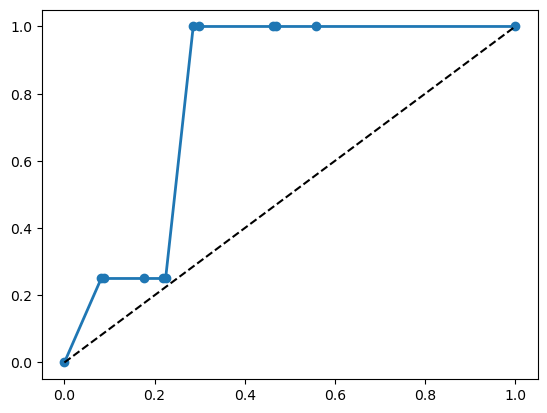

In [18]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba, pos_label = 1)
plt.plot(fpr, tpr, '-o', linewidth=2)
plt.plot([0,1], [0,1], 'k--' )

In [19]:
print(fpr)
print(tpr)
print(thresholds)

[0.         0.08163265 0.08843537 0.17687075 0.21768707 0.2244898
 0.28571429 0.29931973 0.46258503 0.46938776 0.55782313 1.        ]
[0.   0.25 0.25 0.25 0.25 0.25 1.   1.   1.   1.   1.   1.  ]
[1.0893279  0.08932795 0.08800129 0.06219058 0.06123986 0.04128997
 0.04064564 0.04064491 0.04001023 0.02829289 0.02784549 0.02740447]


In [20]:
thr_opt = thresholds[6]

### Setting threshold and evaluating on test

In [21]:
y_test_pred = grid.predict(X_test)
y_test_proba = grid.predict_proba(X_test)[:,1]
y_test_final = y_test_proba.copy()
y_test_final[y_test_proba >= thr_opt] = 1
y_test_final[y_test_proba < thr_opt] = 0
print(confusion_matrix(y_test, y_test_final))
print('Test Metrics')
print('False Positive Rate: ', 34/(34 + 104))
print('True Positive Rate: ', 12/(12 + 0))

[[104  42]
 [  0   4]]
Test Metrics
False Positive Rate:  0.2463768115942029
True Positive Rate:  1.0


In [22]:
y_train_pred = grid.predict(X_train)
y_train_proba = grid.predict_proba(X_train)[:,1]
y_train_final = y_train_proba.copy()
y_train_final[y_train_proba >= thr_opt] = 1
y_train_final[y_train_proba < thr_opt] = 0
print(confusion_matrix(y_train, y_train_final))
print('Train Metrics')
print('False Positive Rate: ', 18/(18 + 166))
print('True Positive Rate: ', 16/(16))

[[138  57]
 [  0   5]]
Train Metrics
False Positive Rate:  0.09782608695652174
True Positive Rate:  1.0


In [23]:
y_val_pred = grid.predict(X_val)
y_val_proba = grid.predict_proba(X_val)[:,1]
y_val_final = y_val_proba.copy()
y_val_final[y_val_proba >= thr_opt] = 1
y_val_final[y_val_proba < thr_opt] = 0
print(confusion_matrix(y_val, y_val_final))
print('Validation Metrics')
print('False Positive Rate: ', 18/(18 + 120))
print('True Positive Rate: ', 12/(12 + 0))

[[105  42]
 [  0   4]]
Validation Metrics
False Positive Rate:  0.13043478260869565
True Positive Rate:  1.0


### Embedded Feature Importance 

Text(0.5, 0, 'Feature Importance')

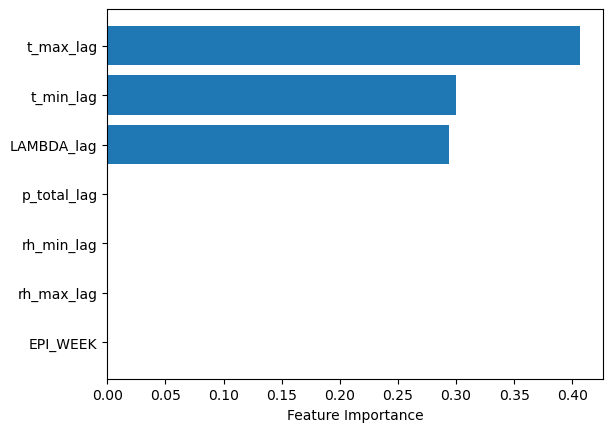

In [24]:
sorted_params = grid.best_estimator_.feature_importances_.argsort()
plt.barh(df.columns[sorted_params], grid.best_estimator_.feature_importances_[sorted_params])
plt.xlabel('Feature Importance')

### SHAP Values

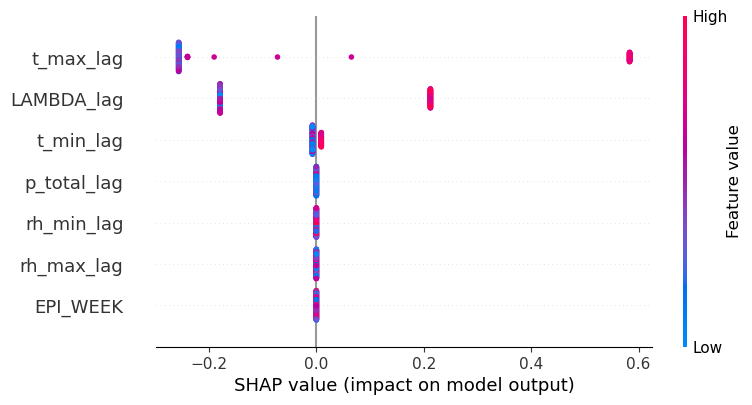

In [25]:
explainer = shap.Explainer(grid.best_estimator_)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values)

## Visualizing predictions - where do we fail?

In [26]:
y_pred_proba = grid.predict_proba(X)[:,1]
y_pred_final = y_pred_proba.copy()
y_pred_final[y_pred_proba >= thr_opt] = 1
y_pred_final[y_pred_proba < thr_opt] = 0

In [27]:
confusion_matrix(y, y_pred_final)

array([[347, 141],
       [  0,  13]], dtype=int64)

In [28]:
print('True positive rate: ', 40/(40 + 0))
print('False positive rate: ', 70/(70 + 390))

True positive rate:  1.0
False positive rate:  0.15217391304347827


### False negatives, which is what worries us the most

In [29]:
fn = ((y == 1) & (y_pred_final == 0))
sem_fn = X[fn]

In [30]:
sem_fn

,EPI_WEEK,rh_max_lag,rh_min_lag,t_min_lag,t_max_lag,LAMBDA_lag,p_total_lag


### False positives

In [31]:
fp = ((y == 0) & (y_pred_final == 1))
sem_fp = X[fp]

In [32]:
sem_fp['EPI_WEEK'].value_counts()

22    8
12    8
17    8
15    8
18    7
21    7
13    7
14    7
19    6
16    6
24    5
9     5
8     5
20    5
11    5
48    5
23    4
47    3
51    3
10    3
1     3
25    3
7     3
52    2
2     2
6     2
4     2
26    2
53    1
3     1
27    1
29    1
43    1
50    1
44    1
Name: EPI_WEEK, dtype: int64

### Classifying and labeling each situation

In [33]:
fn = ((y == 1) & (y_pred_final == 0))
fp = ((y == 0) & (y_pred_final == 1))
tn = ((y == 0) & (y_pred_final == 0))
tp = ((y == 1) & (y_pred_final == 1))

In [34]:
Z = X.copy()
Z['label'] = 0

In [35]:
Z.loc[fn,'label'] = 'FN'
Z.loc[fp,'label'] = 'FP'
Z.loc[tn,'label'] = 'TN'
Z.loc[tp, 'label'] = 'TP'

In [36]:
Z['tplot'] = np.array(df_tplot)
Z['CASES_100K'] = np.array(df_cases)

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


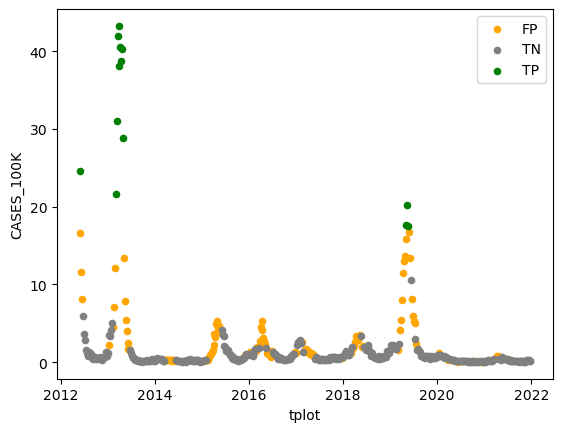

In [37]:
fig, ax = plt.subplots()

colors = {'TP':'green', 'TN':'gray', 'FP':'orange', 'FN':'red'}

grouped = Z.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='tplot', y='CASES_100K', label=key, color=colors[key])

plt.show()